In [1]:
import numpy as np
import seaborn as sns; sns.set()
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import ast

%load_ext autoreload
%autoreload 2


path_root = '/mnt/TERA/Data/reddit_topics'
path_data = join(path_root, 'safe_links_all')



# Idea

Since we have the title texts and the subreddit, it might make sense to train a classifier with input X = title and label Y = subreddit. Then finding similar posts to a query X' could be achieved by applying the classifier, collecting all X in the same class as X' and e.g. finding k nearest neighbors in an embedding space, which could be one of the classifier's top-most layers.

I'll try a fairly simple Bag of Words based approach by count-vectorizing the titles (after lemmatization and other preprocessing).

IMO a much simpler and potentially much more efficient model would be to simply use a character level RNN for the classifier, because 1) the titles are fairly short and 2) there's lots of data, so that the model is able to "learn the language" properly from the dataset. Since the instructions were quite specific with the approach, 

# Data mangling:

## Load, filter and save as CSV:

In [44]:
image_types = ['.jpg', '.png']
df = []
with open(path_data, 'r') as f:
    for n, line in enumerate(f):
        #print(f'\r{n}', end='')
        try:
            lst = ast.literal_eval(line)  # [subreddit, submission title, submitted link, comments link, short name]
        except ValueError:
            #print('ValueError')
            continue
        if any([x in lst[2] for x in image_types]): 
            df.append(lst)
        if len(df) > 10000:  # testing with a lot smaller dataset first
            break
            
df = pd.DataFrame(df)
df.columns = ['subreddit', 'submission_title', 'submission_link', 'comments_link', 'short_name']
df.head()

# Save as CSV:
df.to_csv(join(path_root, 'img_reddits.csv'), index=False)

In [45]:
df.head()

,subreddit,submission_title,submission_link,comments_link,short_name
0,funny,ITT: Things you hate that everyone else likes....,http://i.imgur.com/xvCP4.jpg,/r/funny/comments/eut3m/itt_things_you_hate_th...,t3_eut3m
1,WTF,This is the picture they're using to recruit p...,http://i.imgur.com/QDmzn.jpg,/r/WTF/comments/eut3k/this_is_the_picture_they...,t3_eut3k
2,funny,The Businessman Game - search Google Images fo...,http://www.customs.govt.nz/NR/rdonlyres/8F5ECF...,/r/funny/comments/eut35/the_businessman_game_s...,t3_eut35
3,fffffffuuuuuuuuuuuu,"two people, one shitter...",http://i.imgur.com/50VPz.png,/r/fffffffuuuuuuuuuuuu/comments/eut2n/two_peop...,t3_eut2n
4,wow,Wife is in bed early....CRAPFUCKSHIT...AAAAAAA...,http://i.imgur.com/94ZXF.jpg,/r/wow/comments/eut2j/wife_is_in_bed_earlycrap...,t3_eut2j


## Lemmatize and preprocess:

In [2]:
df = pd.read_csv(join(path_root, 'img_reddits.csv'))

df = df[['subreddit', 'submission_title']]
df_orig = df.copy()
df.head()

,subreddit,submission_title
0,funny,ITT: Things you hate that everyone else likes....
1,WTF,This is the picture they're using to recruit p...
2,funny,The Businessman Game - search Google Images fo...
3,fffffffuuuuuuuuuuuu,"two people, one shitter..."
4,wow,Wife is in bed early....CRAPFUCKSHIT...AAAAAAA...


In [3]:
import spacy
nlp = spacy.load('en')

def lemmatizer(string):
    lst = []
    doc = nlp(string)
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':  # TODO: fix, dirty!
            lst.append(token.lemma_)
            
    return lst

submission_titles = df['submission_title'].apply(lemmatizer)  # 1 min for 10k sentences!!
df['submission_title'] = submission_titles
df.head()

,subreddit,submission_title
0,funny,"[itt, thing, hate, like, start]"
1,WTF,"[this, picture, recruit, police, brutality, ab..."
2,funny,"[the, businessman, game, search, google, image..."
3,fffffffuuuuuuuuuuuu,"[people, shitter]"
4,wow,"[wife, bed, early, crapfuckshit, aaaaaaa, sfw]"


In [4]:
# only subreddits with > min_posts posts:

min_posts = 100

top_subreddits = df['subreddit'].loc[(df['subreddit'].value_counts() > min_posts).values].unique()
print(top_subreddits)

df_top = df.loc[df.subreddit.isin(top_subreddits)]
df_top.head()

['funny' 'WTF' 'fffffffuuuuuuuuuuuu' 'wow' 'AdviceAnimals' 'reddit.com'
 'pics']


,subreddit,submission_title
0,funny,"[itt, thing, hate, like, start]"
1,WTF,"[this, picture, recruit, police, brutality, ab..."
2,funny,"[the, businessman, game, search, google, image..."
3,fffffffuuuuuuuuuuuu,"[people, shitter]"
4,wow,"[wife, bed, early, crapfuckshit, aaaaaaa, sfw]"


In [5]:
# top N most common keywords per subreddit:
n_keywords = 25

top_kws = df_top.groupby('subreddit').sum()
top_kws

,submission_title
subreddit,
AdviceAnimals,"[gaming, gopher, trouble, horror, games, fuck,..."
WTF,"[this, picture, recruit, police, brutality, ab..."
fffffffuuuuuuuuuuuu,"[people, shitter, how, lose, weight, butter, e..."
funny,"[itt, thing, hate, like, start, the, businessm..."
pics,"[if, die, today, feel, satisfied, drunk, sovie..."
reddit.com,"[wife, bed, early, crapfuckshit, aaaaaaa, sfw,..."
wow,"[wife, bed, early, crapfuckshit, aaaaaaa, sfw,..."


In [6]:
# Collect top words per subreddit and total:

def count_words(lst_of_strs, top_n=10):
    #print(lst_of_strs)
    word_counts = dict()
    for word in lst_of_strs:
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1
            
    # Sort:
    word_counts = {word: word_counts[word] for word in sorted(word_counts, key=word_counts.get, reverse=True)}
    
    # top_n:
    word_counts = {k: word_counts[k] for k in list(word_counts)[:top_n]}
            
    return word_counts

top_all_words = []
top_subreddit_words = dict()

for index, row in top_kws.iterrows():
    #print(row.values)
    cnts = count_words(row.values[0])
    top_subreddit_words[index] = cnts
    #print(cnts)
    for word, _ in cnts.items():
        if word not in top_all_words:
            top_all_words.append(word)
        
print(top_all_words)
print()
print(top_subreddit_words)

['hood', 'dad', 'sap', 'the', 'oblivious', 'time', 'fbf', 'high', 'new', 'this', 'wtf', 'like', 'shit', 'think', 'get', 'reddit', 'look', 'fuck', 'why', 'rage', 'true', 'story', 'troll', 'year', 'comic', 'day', 'pic', 'know', 'a', 'good', 'do', 'wow', 'need', 'blizz', 'wonder', 'want']

{'AdviceAnimals': {'hood': 17, 'dad': 17, 'sap': 16, 'the': 12, 'oblivious': 11, 'time': 10, 'fbf': 9, 'high': 9, 'new': 9, 'this': 8}, 'WTF': {'wtf': 38, 'like': 17, 'this': 16, 'shit': 14, 'think': 13, 'get': 12, 'reddit': 12, 'look': 12, 'fuck': 12, 'why': 11}, 'fffffffuuuuuuuuuuuu': {'rage': 149, 'true': 77, 'story': 75, 'new': 66, 'troll': 66, 'year': 63, 'the': 53, 'time': 43, 'comic': 37, 'day': 34}, 'funny': {'the': 33, 'like': 29, 'pic': 23, 'know': 22, 'this': 21, 'dad': 20, 'a': 19, 'think': 19, 'get': 19, 'new': 18}, 'pics': {'like': 182, 'reddit': 171, 'the': 168, 'this': 140, 'new': 132, 'pic': 107, 'think': 103, 'year': 99, 'get': 91, 'good': 85}, 'reddit.com': {'reddit': 110, 'like': 74,

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# quite ugly having to write a slightly different lemmatizer... but I'm in full panic mode!
def lemmatizer_str(string):
    lst = []
    doc = nlp(string)
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':  # TODO: fix, dirty!
            lst.append(token.lemma_)
            
    return ' '.join(lst)

vocabulary = {word: k for k, word in enumerate(top_all_words)}

vectorizer = CountVectorizer(vocabulary=vocabulary, dtype=np.int32)

titles_vectorized = vectorizer.fit_transform(df_orig.submission_title)  # sparse matrix; [T, len(vocab)]
titles_vectorized

<10001x36 sparse matrix of type '<class 'numpy.int32'>'
	with 8061 stored elements in Compressed Sparse Row format>

In [8]:
# test:
lemmatizer_str('hello worlds whaaat are is was balls')

'hello world whaaat ball'

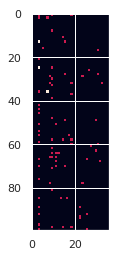

In [14]:
plt.imshow(titles_vectorized.todense()[:100])